# PL波長の予測
前回はrdkit記述子で回帰した。今回はmordredを使う

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.2)  # seabornスタイル適用
import numpy as np
import pandas as pd

from sklearn.cross_decomposition import PLSRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb

import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
# データ読み込み、学習データ＋未知のデータ
data = pd.read_csv('material_data.csv', index_col=0)
# rdkit
des_rdkit = pd.read_csv('descriptor_rdkit.csv', index_col=0)
# FP
fingerprint_df = pd.read_csv('morganFP.csv', index_col=0)
# mordred, 2次元
des_mordred_2d = pd.read_csv('descriptor_mordred_2d.csv', index_col=0)
# mordred, 3次元
des_mordred_3d = pd.read_csv('descriptor_mordred_3d.csv', index_col=0)

data.shape, des_rdkit.shape, fingerprint_df.shape, des_mordred_2d.shape, des_mordred_3d.shape

((233, 3), (233, 217), (233, 2048), (233, 1158), (233, 1826))

# Mordred

In [5]:
# 結合
dataset = pd.concat([data.reset_index(), des_mordred_3d.reset_index(drop=True)], axis=1)

# index降り直し
dataset = dataset.set_index('Material')

dataset.head()

,SMILES,Type,PL,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,...,MID_O,AMID_O,MID_X,AMID_X,MOMI-X,MOMI-Y,MOMI-Z,PBF,Vabc,mZagreb1
Material,,,,,,,,,,,,,,,,,,,,,
BTD1,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=CC=...,BTD,533.0,0,0,30,30,67,39,0,...,0.0,0.0,0.0,0.0,18190.714484,17380.838830,1404.799542,0.618596,476.179458,10.430556
BTD2,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(C...,BTD,540.0,0,0,68,72,127,77,0,...,0.0,0.0,0.0,0.0,107963.417019,105877.044886,5821.789694,1.260219,887.320515,17.708333
BTD3,CC1(C)C2=C(C=CC(C3=CC(N4C(C=CC=C5)=C5C6=C4C=CC...,BTD,538.0,0,0,71,76,127,77,0,...,0.0,0.0,0.0,0.0,125804.193097,123743.082055,5056.330412,1.262891,876.420515,17.708333
BTD4,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(N...,BTD,584.0,0,0,54,54,111,65,0,...,0.0,0.0,0.0,0.0,66186.000047,65535.890414,3552.705389,1.237267,788.613281,15.819444
BTD5,CC1(C)C2=CC(C3=C(N=S=N4)C4=C(C5=CC=C(C6=CC=C(C...,BTD,540.0,0,0,68,72,127,77,0,...,0.0,0.0,0.0,0.0,92519.336505,91934.061815,5768.409851,1.537731,887.320515,17.708333


In [6]:
# 学習データのみを抽出
dataset_train = dataset.dropna(subset='PL')
# TypeとSMILESを消す
dataset_train = dataset_train.drop(['SMILES', 'Type'], axis=1)

dataset_train.shape

(228, 1827)

In [7]:
# infをNaNに置き換え
dataset_train = dataset_train.replace(np.inf, np.nan).fillna(np.nan)
dataset_train_2 = dataset_train.drop(dataset_train.columns[dataset_train.isnull().any()], axis=1)

# 標準偏差が0の記述を削除
dataset_train_3 = dataset_train_2.drop(dataset_train_2.columns[dataset_train_2.std() == 0], axis=1)

dataset_train_2.shape, dataset_train_3.shape

((228, 1425), (228, 1223))

In [8]:
# 欠損値の確認
dataset_train_3.isnull().sum().value_counts()

0    1223
Name: count, dtype: int64

In [9]:
# 目的変数と説明変数に分ける
y = dataset_train_3['PL']
X = dataset_train_3.drop('PL', axis=1)

# Hold-out
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1234)

In [10]:
# 標準化
std = StandardScaler()
autoscaled_X_train = std.fit_transform(X_train)
autoscaled_X_val = std.transform(X_val)

# pandas形式に
autoscaled_X_train = pd.DataFrame(autoscaled_X_train, columns=X_train.columns, index=X_train.index)
autoscaled_X_val = pd.DataFrame(autoscaled_X_val, columns=X_val.columns, index=X_val.index)

# 標準化後、欠損値がないか再度確認
print(autoscaled_X_train.isnull().sum().value_counts())
print(autoscaled_X_val.isnull().sum().value_counts())

0    1222
Name: count, dtype: int64
0    1222
Name: count, dtype: int64


In [11]:
# 可視化の関数

def yyplot(train_df, test_df):
    # ===== 指標の計算 =====
    rmse_tr = np.sqrt(mean_squared_error(train_df['true'], train_df['pred']))
    r2_tr = r2_score(train_df['true'], train_df['pred'])
    mae_tr = mean_absolute_error(train_df['true'], train_df['pred'])

    rmse_te = np.sqrt(mean_squared_error(test_df['true'], test_df['pred']))
    r2_te = r2_score(test_df['true'], test_df['pred'])
    mae_te = mean_absolute_error(test_df['true'], test_df['pred'])

    # ===== グラフ作成 =====
    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)

    # 散布図
    ax.scatter(train_df['true'], train_df['pred'], c='red', label='Train', alpha=0.6)
    ax.scatter(test_df['true'], test_df['pred'], c='blue', label='Val', alpha=0.6)

    # 理想線
    all_true = pd.concat([train_df['true'], test_df['true']])
    min_val = all_true.min()
    max_val = all_true.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')

    # 軸ラベル
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')

    # 範囲調整
    margin = (max_val - min_val) * 0.05
    ax.set_xlim(min_val - margin, max_val + margin)
    ax.set_ylim(min_val - margin, max_val + margin)

    # 評価値表示（右上）
    ax.text(0.05, 0.95, f'Train RMSE = {rmse_tr:.2f}\nTrain MAE  = {mae_tr:.2f}\nTrain R²    = {r2_tr:.2f}',
            transform=ax.transAxes, fontsize=11, color='red', verticalalignment='top')
    ax.text(0.05, 0.80, f'Val  RMSE = {rmse_te:.2f}\nVal  MAE  = {mae_te:.2f}\nVal  R²    = {r2_te:.2f}',
            transform=ax.transAxes, fontsize=11, color='blue', verticalalignment='top')

    # 凡例
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


## PLS

1 0.4115680352054768
2 0.5186563810306039
3 0.5195516702269934
4 0.5599637018913683
5 0.6080756458163592
6 0.6113923282323421
7 0.6198855952123374
8 0.6191358397307387
9 0.5902510136254292
10 0.5576100764006774
11 0.5218751994461595
12 0.565443387396889
13 0.5763721278807465
14 0.6003177879616124
15 0.6014600942794389
16 0.5894666993115993
17 0.5611437438464308
18 0.5376845744030518
19 0.5069322430542385
20 0.4913747728861536
21 0.49384597768795635
22 0.4811572713695599
23 0.4707624125858314
24 0.4516286762657288
25 0.41405932058391715
26 0.3769188657225263
27 0.3529878485333082
28 0.3518924792030732
29 0.3035576542508148
30 0.27270735052621164
31 0.2532355952355442
32 0.24926067469927582
33 0.22483033009121278
34 0.1962106336690086
35 0.16478172798372182
36 0.13856168404175873
37 0.11966115843018366
38 0.12101815039030694
39 0.12349122642053234
40 0.12067984681205324
41 0.11708491474088456
42 0.10855376731057542
43 0.10612420883016604
44 0.09912408376678783
45 0.09151617711672
46 0.08

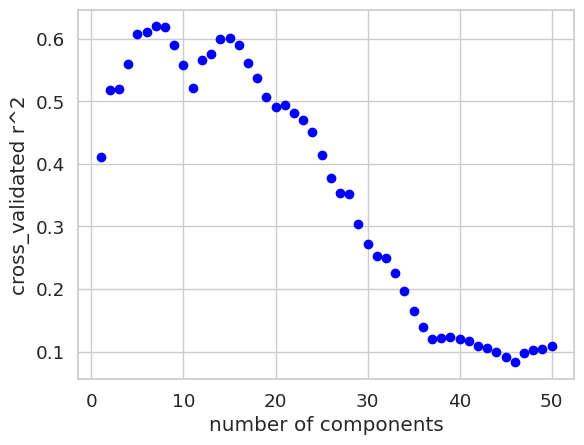

In [12]:
# CVによる成分数の最適化

# 使用する主成分の最大数。説明変数の数より小さい必要があります
max_number_of_principal_components = 50

# N-fold CV の N
fold_number = 5  

# 空のリストを用意
components = []
r2_in_cv_all = []

for component in range(1, max_number_of_principal_components+1):
    # PLS
    model = PLSRegression(n_components=component)
    # CV
    estimated_y_cv = cross_val_predict(model, autoscaled_X_train, y_train,
                                       cv=fold_number)
    estimated_y_cv = pd.DataFrame(estimated_y_cv)
    
    # r2を計算
    r2_in_cv = r2_score(y_train, estimated_y_cv)
    
    # 成分数とr2を表示
    print(component, r2_in_cv)
    
    # r2とcomponentを追加
    components.append(component)
    r2_in_cv_all.append(r2_in_cv)

# 成分数毎のr^2をプロットし、CV後のr^2が最大の時を、最適成分数として抽出

plt.scatter(components, r2_in_cv_all, c='blue')
plt.xlabel('number of components')
plt.ylabel('cross_validated r^2')
plt.show()

In [13]:
optimal_component_number = components[r2_in_cv_all.index(max(r2_in_cv_all))]

print('最適な主成分数 :', optimal_component_number)

最適な主成分数 : 7


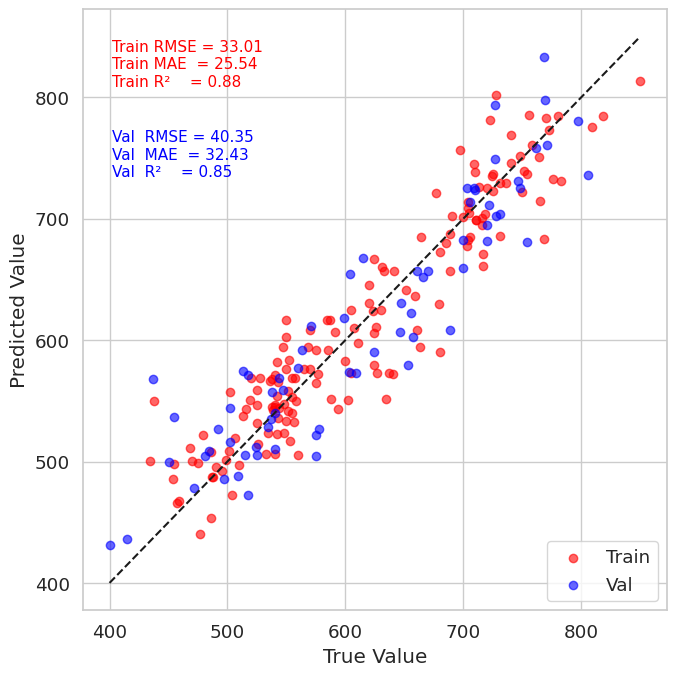

In [14]:
# 予測

# ===== PLSモデルの構築（n_components=6） =====
pls_model = PLSRegression(n_components=optimal_component_number)

# ===== モデル学習 =====
pls_model.fit(autoscaled_X_train, y_train)

# ===== 予測 =====
y_train_pred = pls_model.predict(autoscaled_X_train)
y_val_pred = pls_model.predict(autoscaled_X_val)

# ===== 可視化用データフレーム作成 =====
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred
})

# ===== 可視化 =====
yyplot(train_df, val_df)


- しっかり機能した、rdkitの時よりも精度いいね

## RandomForest

In [15]:
# デフォルト
model_rf = RandomForestRegressor(random_state=1234)

# モデル構築、予測
model_rf.fit(autoscaled_X_train, y_train)
y_train_pred = model_rf.predict(autoscaled_X_train)
y_val_pred = model_rf.predict(autoscaled_X_val)

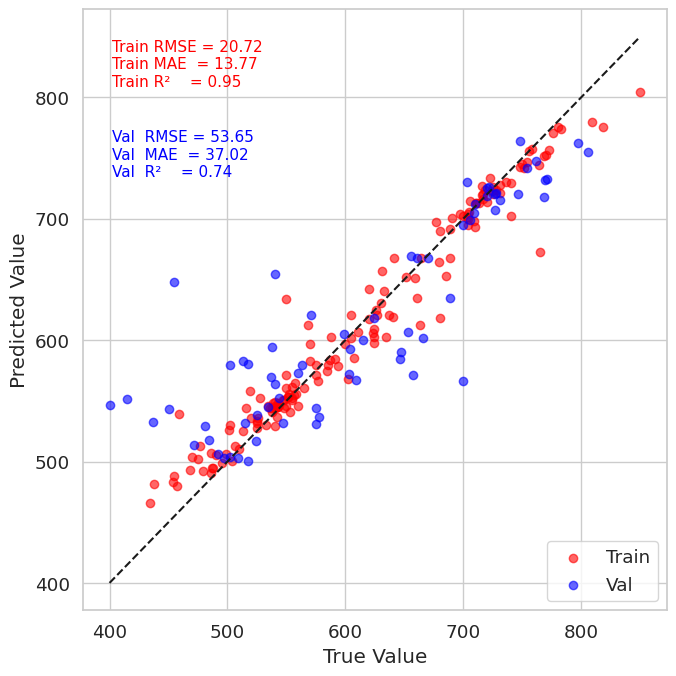

In [16]:
# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

## RF+optuna

In [17]:
def objective_rf(trial):
    # ハイパーパラメータのサンプリング
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # モデル定義
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=0,
        n_jobs=-1
    )

    # モデル学習
    model.fit(autoscaled_X_train, y_train)

    # 検証データでRMSEを評価
    y_val_pred = model.predict(autoscaled_X_val)
    rmse = mean_squared_error(y_val, y_val_pred)
    return rmse

In [18]:
# 学習
study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=50)

[I 2025-06-25 20:25:29,027] A new study created in memory with name: no-name-b07012ff-5e17-4ad1-a140-a10878f1a5f2
[I 2025-06-25 20:25:29,543] Trial 0 finished with value: 3990.7720747552153 and parameters: {'n_estimators': 238, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 3990.7720747552153.
[I 2025-06-25 20:25:29,723] Trial 1 finished with value: 3443.97333006963 and parameters: {'n_estimators': 76, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 3443.97333006963.
[I 2025-06-25 20:25:30,125] Trial 2 finished with value: 2665.9761533081446 and parameters: {'n_estimators': 81, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 2665.9761533081446.
[I 2025-06-25 20:25:30,520] Trial 3 finished with value: 3103.42061873962 and parameters: {'n_estimators': 118, 'max_depth': 8, 'min_samples_

In [19]:
study.best_params

{'n_estimators': 60,
 'max_depth': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_features': None}

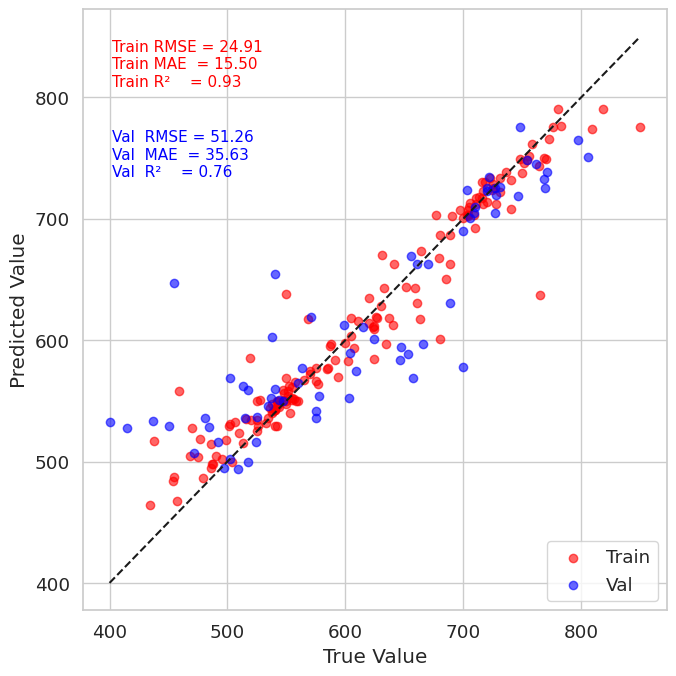

In [20]:
# 最良ハイパーパラメータで再学習
best_params = study.best_params
model_rf_optuna = RandomForestRegressor(**best_params, random_state=0, n_jobs=-1)
model_rf_optuna.fit(autoscaled_X_train, y_train)

# 予測
y_train_pred = model_rf_optuna.predict(autoscaled_X_train)
y_val_pred = model_rf_optuna.predict(autoscaled_X_val)

# 可視化
train_df = pd.DataFrame({'true': y_train.reset_index(drop=True), 'pred': y_train_pred})
val_df = pd.DataFrame({'true': y_val.reset_index(drop=True), 'pred': y_val_pred})
yyplot(train_df, val_df)


/tmp/ipykernel_670/2272905558.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_rf['feature'][:10],


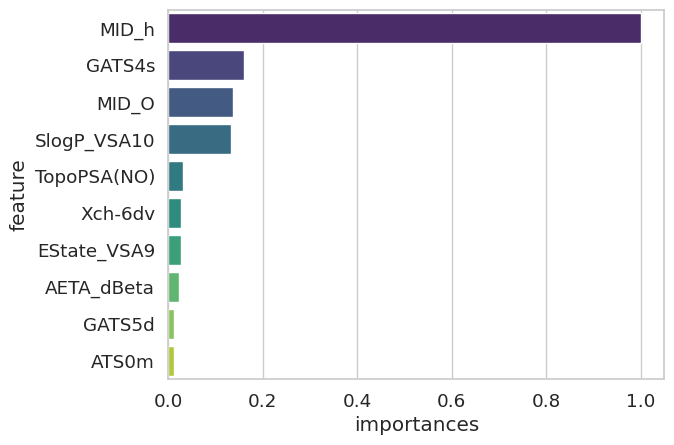

In [21]:
# 特徴量重要度を出す
feature_map_rf = pd.DataFrame([X_train.columns, model_rf_optuna.feature_importances_]).T
feature_map_rf.columns = ['feature', 'importances']

# 降順に
feature_map_rf = feature_map_rf.sort_values('importances', ascending=False)

# 規格化
feature_map_rf['importances'] = feature_map_rf['importances'] / feature_map_rf['importances'].max()

# 可視化
sns.barplot(y=feature_map_rf['feature'][:10],
            x=feature_map_rf['importances'][:10],
            palette='viridis')
plt.show()

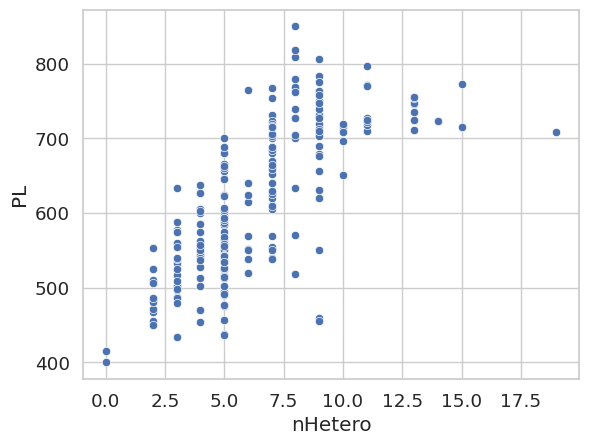

In [22]:
# 予測に役立った説明変数と目的関数の関係をplot
sns.scatterplot(x='nHetero',
                y='PL',
                data=dataset_train)

plt.show()

## XGBoost

[0]	validation_0-rmse:438.93818
[1]	validation_0-rmse:314.78463
[2]	validation_0-rmse:228.38169
[3]	validation_0-rmse:168.29325
[4]	validation_0-rmse:126.38063
[5]	validation_0-rmse:97.57223
[6]	validation_0-rmse:79.70162
[7]	validation_0-rmse:66.16105
[8]	validation_0-rmse:58.22928
[9]	validation_0-rmse:53.07673
[10]	validation_0-rmse:50.14652
[11]	validation_0-rmse:48.96406
[12]	validation_0-rmse:48.23159
[13]	validation_0-rmse:47.82261
[14]	validation_0-rmse:47.69424
[15]	validation_0-rmse:47.22228
[16]	validation_0-rmse:46.82997
[17]	validation_0-rmse:46.66862
[18]	validation_0-rmse:46.63181
[19]	validation_0-rmse:46.71068
[20]	validation_0-rmse:46.74907
[21]	validation_0-rmse:46.78725
[22]	validation_0-rmse:46.88201
[23]	validation_0-rmse:46.79757
[24]	validation_0-rmse:46.76349
[25]	validation_0-rmse:46.72501
[26]	validation_0-rmse:46.73634
[27]	validation_0-rmse:46.78080
[28]	validation_0-rmse:46.79155
[29]	validation_0-rmse:46.79697
[30]	validation_0-rmse:46.79566
[31]	validati

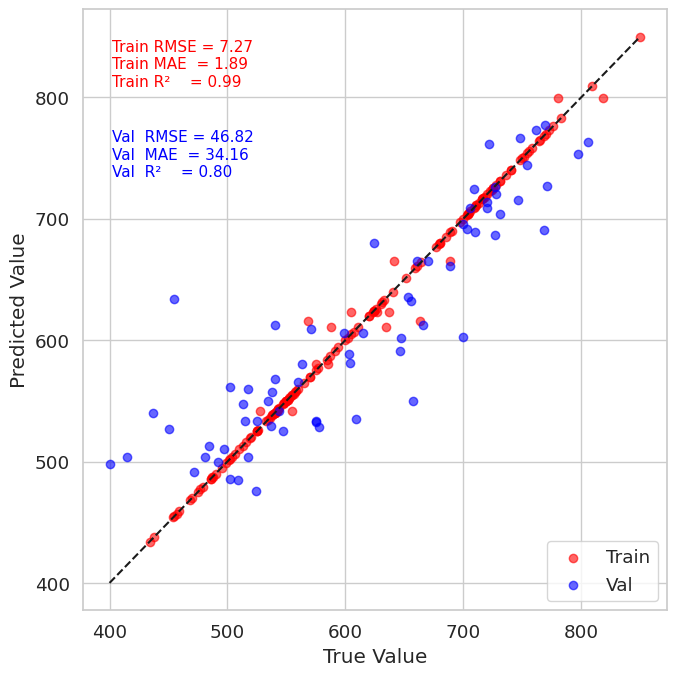

In [23]:
# デフォルトXGB
model_xgb = xgb.XGBRegressor(random_state=1234)

# テストデータの組
eval_set = [(autoscaled_X_val, y_val)]

# モデル学習
model_xgb.fit(autoscaled_X_train, y_train, eval_set=eval_set)

# 予測
y_train_pred = model_xgb.predict(autoscaled_X_train)
y_val_pred = model_xgb.predict(autoscaled_X_val)

# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

## XGBoost+optuna

In [24]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'tree_method': 'hist',  # CPUで高速にする場合
    }

    # テストデータの組
    eval_set = [(autoscaled_X_val, y_val)]

    model_xgb_optuna = xgb.XGBRegressor(**param)

    model_xgb_optuna.fit(autoscaled_X_train, y_train, eval_set=eval_set, verbose=0)

    y_pred = model_xgb_optuna.predict(autoscaled_X_val)
    r2 = r2_score(y_val, y_pred)

    return r2  # 最大化したいのでそのまま返す

In [25]:
# 学習
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # 試行回数や時間は任意

[I 2025-06-25 20:25:55,959] A new study created in memory with name: no-name-3642669a-57ed-4589-906f-42b567b19483


[I 2025-06-25 20:25:59,050] Trial 0 finished with value: 0.7641125838822818 and parameters: {'n_estimators': 258, 'max_depth': 3, 'learning_rate': 0.2658267568149585, 'subsample': 0.9266315251304253, 'colsample_bytree': 0.8505372254667977, 'reg_alpha': 1.9879067038299928e-07, 'reg_lambda': 1.763208687834112e-05}. Best is trial 0 with value: 0.7641125838822818.
[I 2025-06-25 20:26:00,624] Trial 1 finished with value: 0.7380137099301254 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2409965212087918, 'subsample': 0.9852211399538191, 'colsample_bytree': 0.9033413664800791, 'reg_alpha': 1.5115280337216537, 'reg_lambda': 9.821766864800808e-05}. Best is trial 0 with value: 0.7641125838822818.
[I 2025-06-25 20:26:03,163] Trial 2 finished with value: 0.735925722454779 and parameters: {'n_estimators': 265, 'max_depth': 3, 'learning_rate': 0.20912639333546348, 'subsample': 0.6233016686248911, 'colsample_bytree': 0.8616753252779774, 'reg_alpha': 1.9080027281982014e-08, '

In [26]:
# ハイパーパラメータ・スコアの確認
print("Best trial:")
trial = study.best_trial

print(f"  R²: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  R²: 0.8615
  Params:
    n_estimators: 105
    max_depth: 8
    learning_rate: 0.13847704567881539
    subsample: 0.8428606360298965
    colsample_bytree: 0.7535668989737699
    reg_alpha: 0.026043921535757845
    reg_lambda: 7.042821735012439


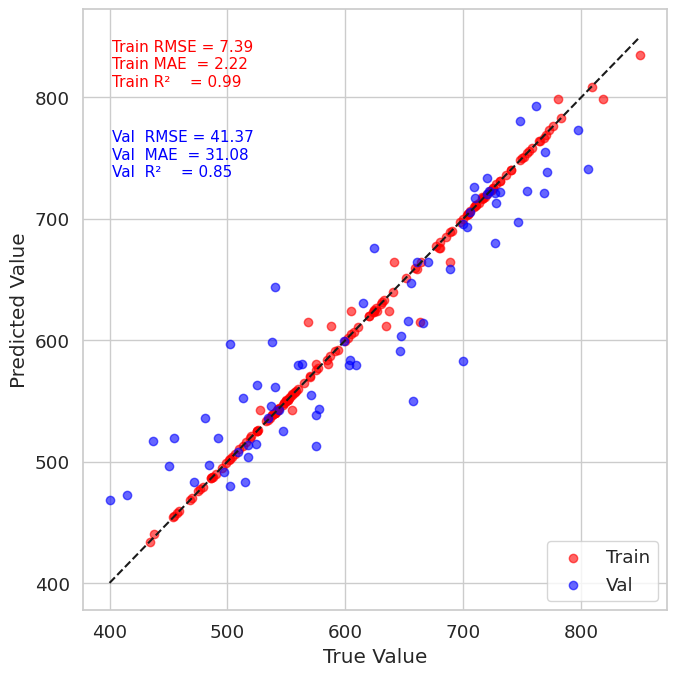

In [27]:
# 再学習
best_params = trial.params
model_xgb_best = xgb.XGBRegressor(**best_params)
model_xgb_best.fit(autoscaled_X_train, y_train, eval_set=eval_set, verbose=0)

# 予測
y_train_pred = model_xgb_best.predict(autoscaled_X_train)
y_val_pred = model_xgb_best.predict(autoscaled_X_val)

# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

/tmp/ipykernel_670/1669432058.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_xgb['feature'][:10],


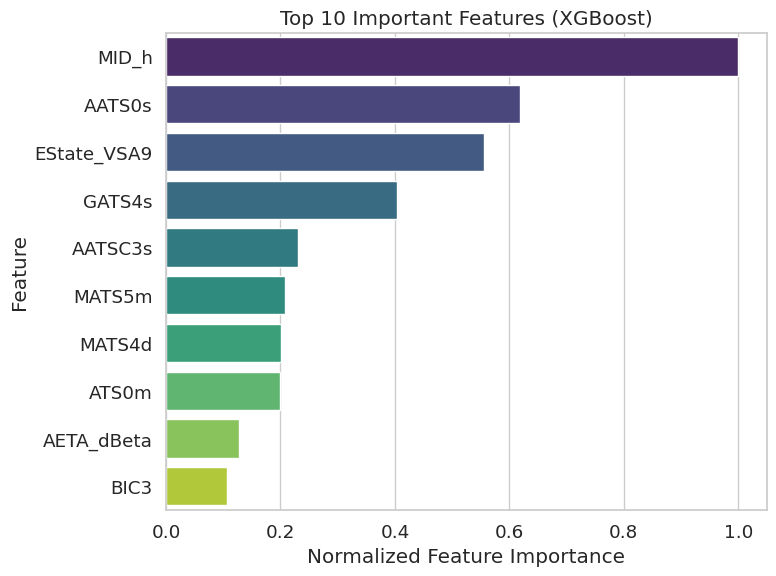

In [28]:
# 特徴量重要度を取得
feature_map_xgb = pd.DataFrame([X_train.columns, model_xgb_best.feature_importances_]).T
feature_map_xgb.columns = ['feature', 'importances']

# 降順に並べ替え
feature_map_xgb = feature_map_xgb.sort_values('importances', ascending=False)

# 規格化（最大値で割る）
feature_map_xgb['importances'] = feature_map_xgb['importances'] / feature_map_xgb['importances'].max()

# 上位10個の特徴量を可視化
plt.figure(figsize=(8, 6))
sns.barplot(y=feature_map_xgb['feature'][:10],
            x=feature_map_xgb['importances'][:10],
            palette='viridis')
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features (XGBoost)')
plt.tight_layout()
plt.show()


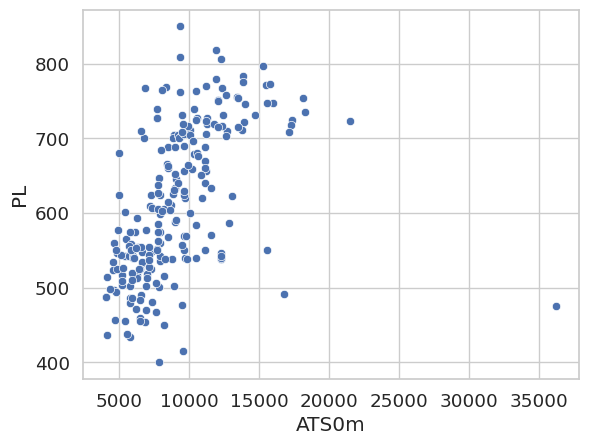

In [29]:
# 予測に役立った説明変数と目的関数の関係をplot
sns.scatterplot(x='ATS0m',
                y='PL',
                data=dataset_train)

plt.show()

- ATS0mはAutocorrelation of Topological Structure（トポロジー自動相関）の略、ラグ（距離）が０（つまり原子自身）、mは重みづけ要素がatomic mass(原子質量)ということ
- ATS0mが高いほど、重い原子が分子内に多く含まれる傾向がある
- ラグ0は「隣接関係」は考慮せず、単純に分子中の重原子の分布に相当

## LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55043
[LightGBM] [Info] Number of data points in the train set: 159, number of used features: 1163
[LightGBM] [Info] Start training from score 613.924528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

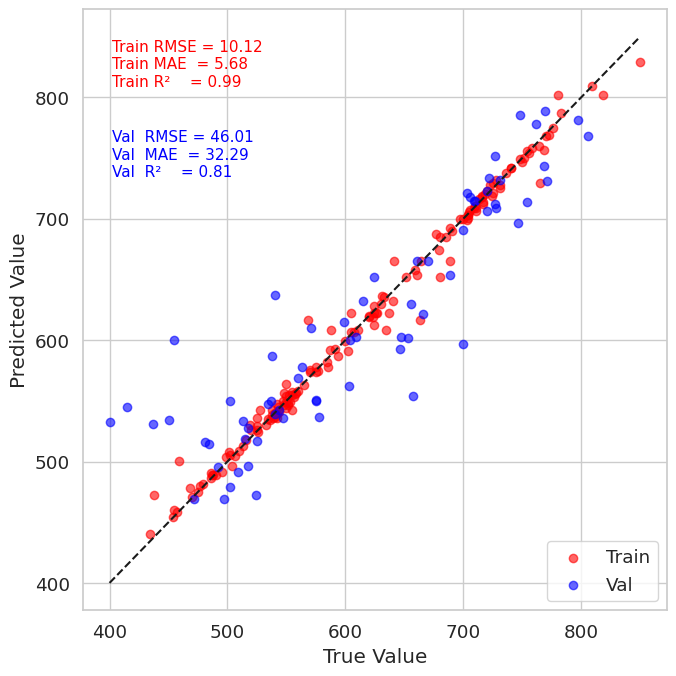

In [30]:
# デフォルト
model_lgb = lgb.LGBMRegressor(random_state=1234)

eval_set = [(autoscaled_X_val, y_val)]

# モデル学習
model_lgb.fit(autoscaled_X_train, y_train, eval_set=eval_set)

# 予測
y_train_pred = model_lgb.predict(autoscaled_X_train)
y_val_pred = model_lgb.predict(autoscaled_X_val)

# 可視化
pred_train_df = pd.concat([y_train.reset_index(drop=True), pd.Series(y_train_pred)], axis=1)
pred_train_df.columns = ['true', 'pred']

pred_val_df = pd.concat([y_val.reset_index(drop=True), pd.Series(y_val_pred)], axis=1)
pred_val_df.columns = ['true', 'pred']

yyplot(pred_train_df, pred_val_df)

## LightGBM+optuna

In [31]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',  # LightGBMが内部で使う評価指標
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'verbosity': -1,
    }

    model = lgb.LGBMRegressor(**param)
    eval_set = [(autoscaled_X_val, y_val)]
    model.fit(autoscaled_X_train, y_train, eval_set=eval_set)

    y_pred = model.predict(autoscaled_X_val)
    return r2_score(y_val, y_pred)

# 最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # 50試行 or 600秒

# 結果表示
print("Best trial:")
print(f"  R²: {study.best_trial.value:.4f}")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-25 20:29:21,899] A new study created in memory with name: no-name-51892a48-c232-418d-ad89-e7066841e3ef
[I 2025-06-25 20:29:22,070] Trial 0 finished with value: 0.8191917291614557 and parameters: {'n_estimators': 131, 'learning_rate': 0.10359579614427936, 'max_depth': 4, 'num_leaves': 42, 'subsample': 0.7348875892426865, 'colsample_bytree': 0.5282168409680454, 'reg_alpha': 0.45507688161228393, 'reg_lambda': 0.00017350110110278676}. Best is trial 0 with value: 0.8191917291614557.
[I 2025-06-25 20:29:22,361] Trial 1 finished with value: 0.8117778165273342 and parameters: {'n_estimators': 251, 'learning_rate': 0.03771941246269082, 'max_depth': 4, 'num_leaves': 72, 'subsample': 0.801588072187714, 'colsample_bytree': 0.5250227989278835, 'reg_alpha': 0.17091881290123556, 'reg_lambda': 2.275540765235932e-05}. Best is trial 0 with value: 0.8191917291614557.
[I 2025-06-25 20:29:22,634] Trial 2 finished with value: 0.8133869676389138 and parameters: {'n_estimators': 180, 'learning_rate

Best trial:
  R²: 0.8358
    n_estimators: 289
    learning_rate: 0.16842675841901664
    max_depth: 10
    num_leaves: 34
    subsample: 0.7323276696492867
    colsample_bytree: 0.7941623272613748
    reg_alpha: 5.033753003467033e-06
    reg_lambda: 0.004686588393036141


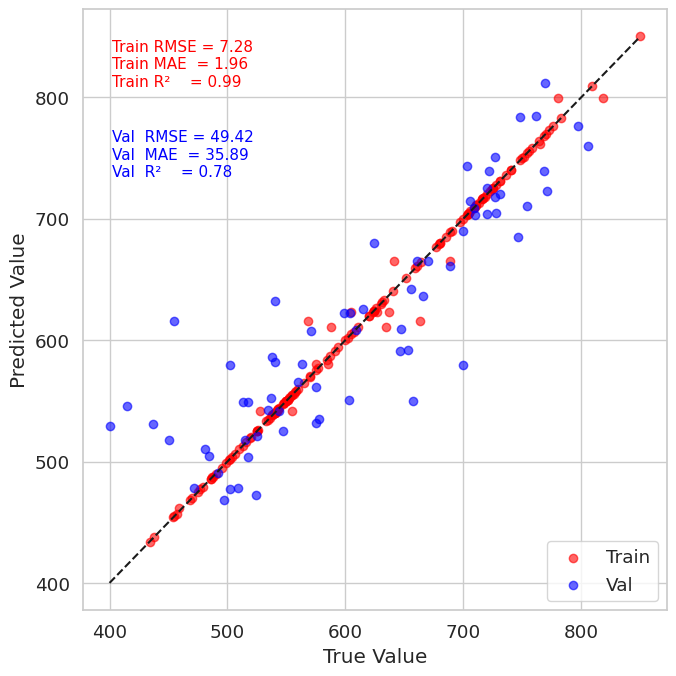

In [32]:
# モデル再構築
best_params = study.best_trial.params

model_lgb_best = lgb.LGBMRegressor(**best_params)
model_lgb_best.fit(autoscaled_X_train, y_train)

# 予測
y_train_pred = model_lgb_best.predict(autoscaled_X_train)
y_val_pred = model_lgb_best.predict(autoscaled_X_val)

# 可視化などに使うデータ整形
pred_train_df = pd.DataFrame({'true': y_train.values, 'pred': y_train_pred})
pred_val_df = pd.DataFrame({'true': y_val.values, 'pred': y_val_pred})

# 例：yyplot などに渡せる形式
yyplot(pred_train_df, pred_val_df)


/tmp/ipykernel_670/1283215102.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_lgb['feature'][:10],


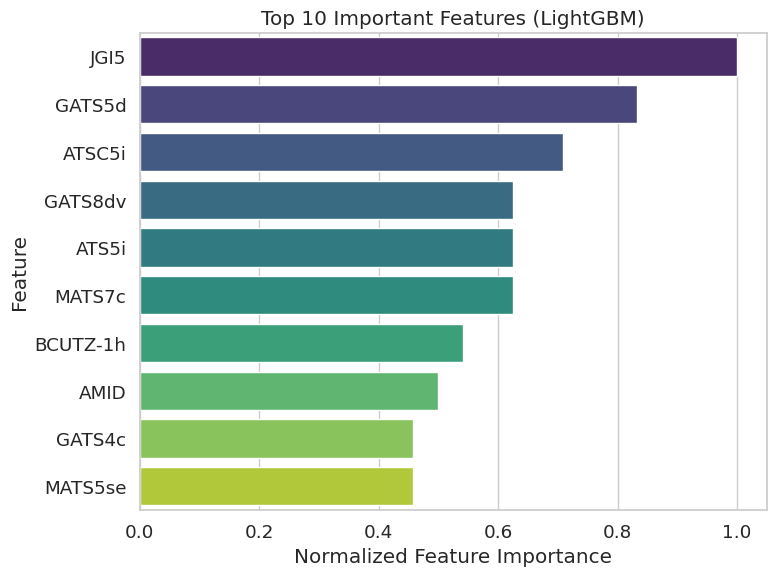

In [33]:
# 特徴量重要度の取得
feature_map_lgb = pd.DataFrame({
    'feature': X_train.columns,
    'importances': model_lgb_best.feature_importances_
})

# 降順に並べ替え
feature_map_lgb = feature_map_lgb.sort_values('importances', ascending=False)

# 規格化（最大値で割る）
feature_map_lgb['importances'] = feature_map_lgb['importances'] / feature_map_lgb['importances'].max()

# 上位10個の特徴量を可視化
plt.figure(figsize=(8, 6))
sns.barplot(y=feature_map_lgb['feature'][:10],
            x=feature_map_lgb['importances'][:10],
            palette='viridis')
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features (LightGBM)')
plt.tight_layout()
plt.show()

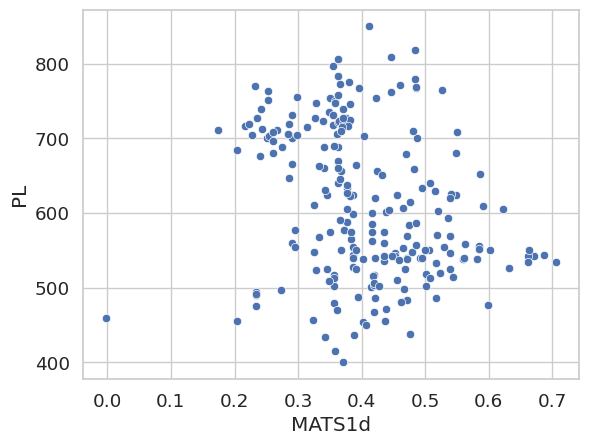

In [34]:
# 予測に役立った説明変数と目的関数の関係をplot
sns.scatterplot(x='MATS1d',
                y='PL',
                data=dataset_train)

plt.show()

## NN

In [35]:
# GPU set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [36]:
# yの標準化
y_scaler = StandardScaler()
autoscaled_y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
autoscaled_y_val = y_scaler.transform(y_val.values.reshape(-1, 1))

In [37]:
# NN定義
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [38]:
# モデル構築
model_nn = MLPRegressor(input_dim=X.shape[1]).to(device)
# 損失関数
criterion = nn.MSELoss()
# 最適化関数
optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-4)

In [39]:
# データセット定義
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Datasetに渡す（.valuesでnumpy化）
train_ds = RegressionDataset(autoscaled_X_train.values, autoscaled_y_train)
val_ds = RegressionDataset(autoscaled_X_val.values, autoscaled_y_val)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16)

In [40]:
# 学習loop
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# 評価
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)

Epoch   0 | Train Loss: 0.6871 | Val Loss: 0.9438
Epoch   1 | Train Loss: 0.4766 | Val Loss: 0.6974
Epoch   2 | Train Loss: 0.3512 | Val Loss: 0.4979
Epoch   3 | Train Loss: 0.3372 | Val Loss: 0.3377
Epoch   4 | Train Loss: 0.2729 | Val Loss: 0.3041
Epoch   5 | Train Loss: 0.2734 | Val Loss: 0.2708
Epoch   6 | Train Loss: 0.3153 | Val Loss: 0.2549
Epoch   7 | Train Loss: 0.2325 | Val Loss: 0.2682
Epoch   8 | Train Loss: 0.1695 | Val Loss: 0.2713
Epoch   9 | Train Loss: 0.2400 | Val Loss: 0.2478
Epoch  10 | Train Loss: 0.2054 | Val Loss: 0.2413
Epoch  11 | Train Loss: 0.2067 | Val Loss: 0.2629
Epoch  12 | Train Loss: 0.2205 | Val Loss: 0.2522
Epoch  13 | Train Loss: 0.2957 | Val Loss: 0.2363
Epoch  14 | Train Loss: 0.1672 | Val Loss: 0.2257
Epoch  15 | Train Loss: 0.2210 | Val Loss: 0.2313
Epoch  16 | Train Loss: 0.2534 | Val Loss: 0.2625
Epoch  17 | Train Loss: 0.1904 | Val Loss: 0.2415
Epoch  18 | Train Loss: 0.1959 | Val Loss: 0.2204
Epoch  19 | Train Loss: 0.3137 | Val Loss: 0.2282


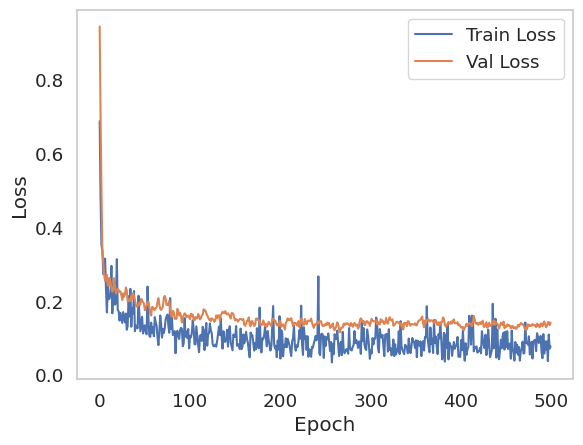

In [41]:
# 学習実行
n_epochs = 500

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = train(model_nn, train_dl, optimizer, criterion, device)
    val_loss = evaluate(model_nn, val_dl, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# 学習推移の可視化
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


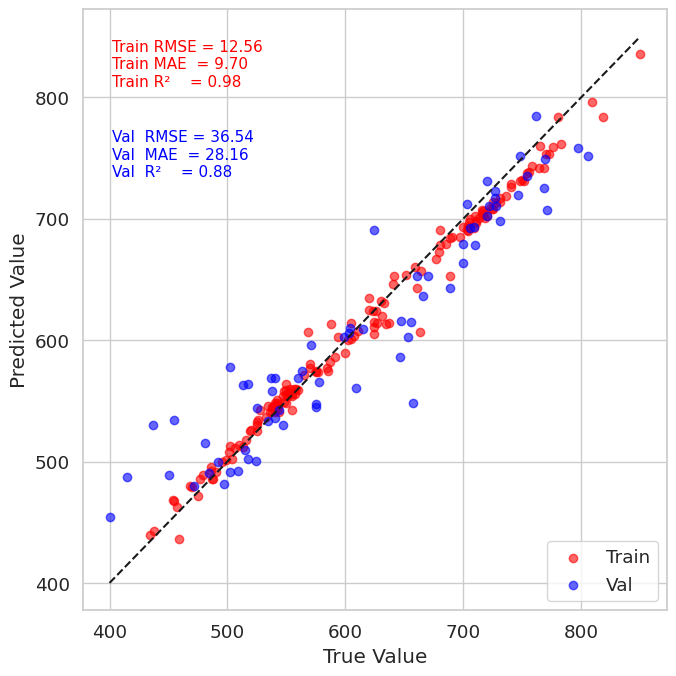

In [42]:
# 推論関数
def predict(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().numpy()
            preds.append(y_pred)
    return np.vstack(preds)

# 推論用（shuffleなし）DataLoaderを用意、train_dl を shuffle=True で作って学習したあと、その同じ train_dl で推論してしまうと、y_train と pred の順序が一致しなくなって、結果がズレます。
train_dl_eval = DataLoader(train_ds, batch_size=32, shuffle=False)
val_dl_eval = DataLoader(val_ds, batch_size=32, shuffle=False)

# 推論 & 逆変換
y_train_pred = y_scaler.inverse_transform(predict(model_nn, train_dl_eval, device))
y_val_pred = y_scaler.inverse_transform(predict(model_nn, val_dl_eval, device))

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)


## NN+optuna

In [43]:
import optuna
import torch.nn.functional as F

def define_model(trial, input_dim):
    layers = []
    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_dim = trial.suggest_int("hidden_dim", 64, 1024)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    activation_name = trial.suggest_categorical("activation", ["relu", "leaky_relu"])

    in_dim = input_dim
    for i in range(n_layers):
        layers.append(nn.Linear(in_dim, hidden_dim))
        if activation_name == "relu":
            layers.append(nn.ReLU())
        else:
            layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(dropout_rate))
        in_dim = hidden_dim

    layers.append(nn.Linear(in_dim, 1))
    return nn.Sequential(*layers)

def objective(trial):
    # データ準備（定義済み）
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size)

    model = define_model(trial, input_dim=X.shape[1]).to(device)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

    # 学習ループ（簡略版）
    for epoch in range(30):
        model.train()
        for X_batch, y_batch in train_dl:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()

    # 検証
    val_loss = evaluate(model, val_dl, criterion, device)  # 前に定義した `evaluate` 関数を使う
    return val_loss


In [44]:
# 学習
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best trial:", study.best_trial.params)

[I 2025-06-25 20:30:18,603] A new study created in memory with name: no-name-0abc9788-b6ff-40d0-a421-53ea5b61d7b5
[I 2025-06-25 20:30:19,084] Trial 0 finished with value: 0.5331282615661621 and parameters: {'batch_size': 128, 'n_layers': 5, 'hidden_dim': 110, 'dropout_rate': 0.39549859517401836, 'activation': 'leaky_relu', 'lr': 0.0036868514490134927, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5331282615661621.
[I 2025-06-25 20:30:19,815] Trial 1 finished with value: 0.17166892190774283 and parameters: {'batch_size': 32, 'n_layers': 3, 'hidden_dim': 523, 'dropout_rate': 0.4841693637459053, 'activation': 'leaky_relu', 'lr': 0.00024017215333609578, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.17166892190774283.
[I 2025-06-25 20:30:20,506] Trial 2 finished with value: 1.3762724995613098 and parameters: {'batch_size': 64, 'n_layers': 5, 'hidden_dim': 816, 'dropout_rate': 0.49969555989912, 'activation': 'relu', 'lr': 0.0010475955441318738, 'optimizer': 'SGD'}. Best is trial 

Best trial: {'batch_size': 32, 'n_layers': 2, 'hidden_dim': 494, 'dropout_rate': 0.2686233308454326, 'activation': 'leaky_relu', 'lr': 0.00032230070940092784, 'optimizer': 'Adam'}


In [45]:
study.best_params

{'batch_size': 32,
 'n_layers': 2,
 'hidden_dim': 494,
 'dropout_rate': 0.2686233308454326,
 'activation': 'leaky_relu',
 'lr': 0.00032230070940092784,
 'optimizer': 'Adam'}

In [46]:
study.best_params['hidden_dim']

494

In [47]:
# モデル定義
class TunedMLP(nn.Module):
    def __init__(self, input_dim):
        super(TunedMLP, self).__init__()
        layers = []
        in_dim = input_dim
        hidden_dim = study.best_params['hidden_dim']
        n_layers = study.best_params['n_layers']
        dropout_rate = study.best_params['dropout_rate']
        activation = nn.LeakyReLU()

        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [48]:
# DataLoader（batch_sizeも反映）
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

# モデル・損失関数・最適化手法
model_nn = TunedMLP(input_dim=X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=study.best_params['lr'])

# 学習
train_losses, val_losses = [], []
for epoch in range(1, 101):
    train_loss = train(model_nn, train_dl, optimizer, criterion, device)
    val_loss = evaluate(model_nn, val_dl, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 001 | Train Loss: 0.7015 | Val Loss: 0.6558
Epoch 002 | Train Loss: 0.3788 | Val Loss: 0.4809
Epoch 003 | Train Loss: 0.2582 | Val Loss: 0.3290
Epoch 004 | Train Loss: 0.2458 | Val Loss: 0.2214
Epoch 005 | Train Loss: 0.1549 | Val Loss: 0.2069
Epoch 006 | Train Loss: 0.1356 | Val Loss: 0.1682
Epoch 007 | Train Loss: 0.1167 | Val Loss: 0.1864
Epoch 008 | Train Loss: 0.0985 | Val Loss: 0.1753
Epoch 009 | Train Loss: 0.1004 | Val Loss: 0.1891
Epoch 010 | Train Loss: 0.1136 | Val Loss: 0.1691
Epoch 011 | Train Loss: 0.1384 | Val Loss: 0.1633
Epoch 012 | Train Loss: 0.0860 | Val Loss: 0.1951
Epoch 013 | Train Loss: 0.0999 | Val Loss: 0.1781
Epoch 014 | Train Loss: 0.0708 | Val Loss: 0.1788
Epoch 015 | Train Loss: 0.1079 | Val Loss: 0.1610
Epoch 016 | Train Loss: 0.0794 | Val Loss: 0.1437
Epoch 017 | Train Loss: 0.0645 | Val Loss: 0.1535
Epoch 018 | Train Loss: 0.0818 | Val Loss: 0.1349
Epoch 019 | Train Loss: 0.0610 | Val Loss: 0.1226
Epoch 020 | Train Loss: 0.0612 | Val Loss: 0.1282


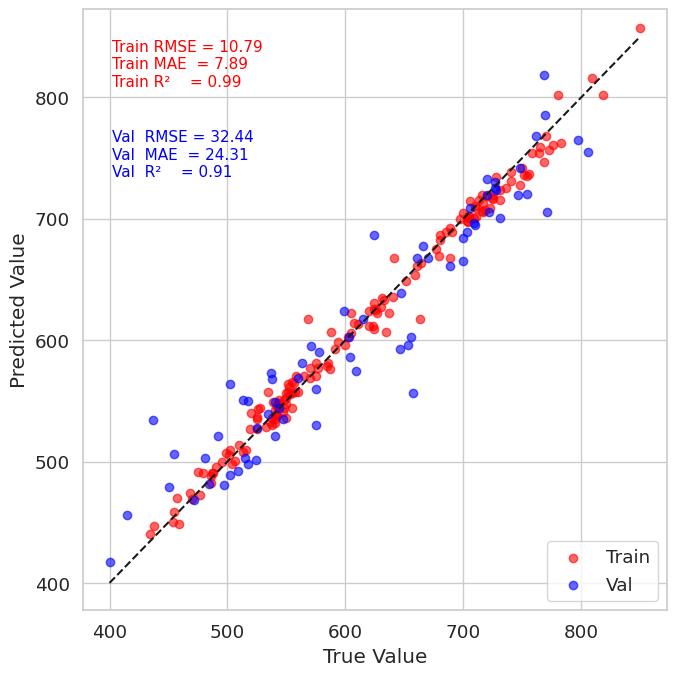

In [49]:
# 推論用DataLoader（shuffle=Falseで固定）
train_dl_eval = DataLoader(train_ds, batch_size=128, shuffle=False)
val_dl_eval = DataLoader(val_ds, batch_size=128, shuffle=False)

# 推論 & 逆変換
y_train_pred = y_scaler.inverse_transform(predict(model_nn, train_dl_eval, device))
y_val_pred = y_scaler.inverse_transform(predict(model_nn, val_dl_eval, device))

# 可視化データ作成
train_df = pd.DataFrame({'true': y_train.reset_index(drop=True), 'pred': y_train_pred.flatten()})
val_df = pd.DataFrame({'true': y_val.reset_index(drop=True), 'pred': y_val_pred.flatten()})

# 可視化
yyplot(train_df, val_df)
